In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as mpl

In [5]:
l = 1
v = 1
d = .1
m = .1
hmax = 10
rate = 0.05
gamma = 1/(1+rate)

In [6]:
def tree_sim(h,c): # c=1 for cut, c = 0 for non cut
    
    if c:
        return 1,v*h-l
    
    else:
        disease = rd.random()<d
        if disease:
            return 1,-l
        gp = rd.random()
        g = 0
        if gp > .5:
            g = min(hmax-h,0)
        elif gp > .25 and gp <= .5:
            g = min(hmax-h,1)
        elif gp > .10 and gp <= .25:
            g = min(hmax-h,2)
        elif gp > .05 and gp <= .10:
            g = min(hmax-h,3)
        elif gp >= 0 and gp <= .05:
            g = min(hmax-h,4)
            
        return h+g, -m

In [7]:
def tree_MDP(): 
    
    vec_proba = np.asarray([.5,.25,.15,.05,.05])*(1-d)
    dynamicsc1 = np.reshape([[np.append(1,[0 for i in range(hmax-1)])] for j in range(hmax)],(hmax,hmax))
    dynamicsc0 = np.reshape([np.append(np.append([0 for i in range(j)],np.asarray([.5,.25,.15,.05,.05])*(1-d)),[0 for i in range(hmax-j-5)]) for j in range(hmax+1-len(vec_proba))],(hmax+1-len(vec_proba),hmax))
    dynamicsc0 = np.append(dynamicsc0, np.append([0 for i in range(hmax+1-len(vec_proba))],np.asarray([.5,.25,.15,.1])*(1-d)))
    dynamicsc0 = np.append(dynamicsc0, np.append([0 for i in range(hmax+2-len(vec_proba))],np.asarray([.5,.25,.25])*(1-d)))
    dynamicsc0 = np.append(dynamicsc0, np.append([0 for i in range(hmax+3-len(vec_proba))],np.asarray([.5,.5])*(1-d)))
    dynamicsc0 = np.append(dynamicsc0, np.append([0 for i in range(hmax+4-len(vec_proba))],(1-d)))
    dynamicsc0 = np.reshape(dynamicsc0,(hmax,hmax))
    
    dynamicsc0 += [np.append(d,[0 for i in range(hmax-1)]) for j in range(hmax)]
    
    dynamics = np.concatenate(([dynamicsc0],[dynamicsc1]),0)
    
    
    def r(h,c):
        
        if c:
            return v*h-l
        else:
            return -m*(1-d)-l*d
        
    return dynamics,r

In [8]:
policy = np.append([0 for i in range(hmax-1)],1)

In [9]:
def evolution(hinit, pol, steps):
    
    h = hinit
    rtot = [0]
    
    for i in range(steps):
        
        r = tree_MDP()[1](h,pol[h-1])
        rtot = np.append(rtot,rtot[-1]+r)
#         print(h,'\t',r,'\t',rtot[-1])
        
    return rtot

In [10]:
# for i in range(100):
#     print(tree_sim(10,0))

In [11]:
np.mean([evolution(1,policy,100) for i in range(100)])

-9.4999999999999982

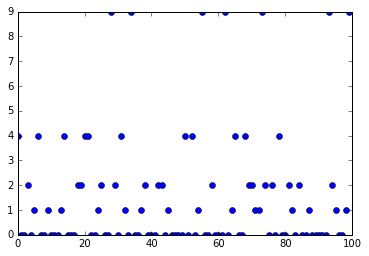

In [12]:
mpl.plot([int(10/rd.randint(1,10)-1) for i in range(100)],'o')

In [13]:
dynamics,r = tree_MDP()

In [14]:
def MCEvaluation(n,Tmax,h0):
    
    Vftot = []
    
    for i in range(n):
        
        T = 0
        h = h0

        rtot = []
        Rtot = []

        for T in range(Tmax):

            action = policy[h-1]

            h,r = tree_sim(h,action)

            rtot = np.append(rtot,r)

            Rtot = np.append(Rtot,np.sum([gamma**t*rtot[t] for t in range(T)]))
            
        Vf = np.mean(Rtot)
        
        Vftot = np.append(Vftot,Vf)
    
    return np.mean(Vftot)
    

In [15]:
Vmc = [MCEvaluation(10,100,h) for h in range(1,hmax+1)]
print(Vmc)

[1.4780276539047428, 2.8616592753462342, 2.9268710961056397, 2.6027493197620371, 3.8298436815902526, 5.1872719113533332, 8.3869063671082582, 5.3856033155852172, 7.9193564574584441, 12.21967235413603]


In [16]:
def Q(x,a,v):
    
    dynamics,r = tree_MDP()
    return r(x,a) + gamma*np.sum([dynamics[a][x-1][y]*v[y] for y in range(hmax)])

In [17]:
def BellmanOperator(w, policy):
    
    dynamics,r = tree_MDP()
    
    return [Q(x,policy[x-1],w) for x in range(1,hmax+1)]
    

In [18]:
def BellmanVf(n, policy):
    
    w = [0 for i in range(hmax)]
    for i in range(n):     
        w = BellmanOperator(w, policy)
        
    return w

In [19]:
BellmanVf(1000, policy)

[3.7455005370172705,
 4.1749922732561595,
 4.6694364136114839,
 5.2506681022258119,
 5.916067257517506,
 6.7613088177914173,
 7.6062998866417564,
 8.6483442087022517,
 9.717107615943787,
 12.567143368587876]

In [20]:
# diff = [MCEvaluation(i,100,1)-BellmanVf(i)[0] for i in range(1000)]
# mpl.figure(figsize=(20,10))
# mpl.plot(diff, 'g',linewidth = 2)

In [21]:
def valueIteration(n):
    
    dynamics,r = tree_MDP()
    
    v = [0 for i in range(hmax)]
    for i in range(n):     
        v = [max([Q(x,a,v) for a in range(2)]) for x in range(1,hmax+1)]
    
    pol = [np.argmax([Q(x,a,v) for a in range(2)]) for x in range(1,hmax+1)]
    
    v = [Q(x,pol[x-1],v) for x in range(1,hmax+1)]
    
    return v,pol
    

In [22]:
valueIteration(1000)

([8.9507142857142643,
  9.6526530612244681,
  10.524489795918347,
  11.524489795918347,
  12.524489795918347,
  13.524489795918347,
  14.524489795918347,
  15.524489795918347,
  16.524489795918349,
  17.524489795918349],
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [23]:
def policyIteration(n):
    
    dynamics,r = tree_MDP()
    
    pol = [1 for x in range(hmax)]
    v = [1 for x in range(hmax)]
        
    for i in range(n):
        
        v = [Q(x,pol[x-1],v) for x in range(1,hmax+1)]
        pol = [np.argmax([Q(x,a,v) for a in range(2)]) for x in range(1,hmax+1)]
        
    return v,pol

In [24]:
policyIteration(1000)

([8.9507142857142643,
  9.6526530612244681,
  10.524489795918347,
  11.524489795918347,
  12.524489795918347,
  13.524489795918347,
  14.524489795918347,
  15.524489795918347,
  16.524489795918349,
  17.524489795918349],
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
Vet = valueIteration(500)[0]

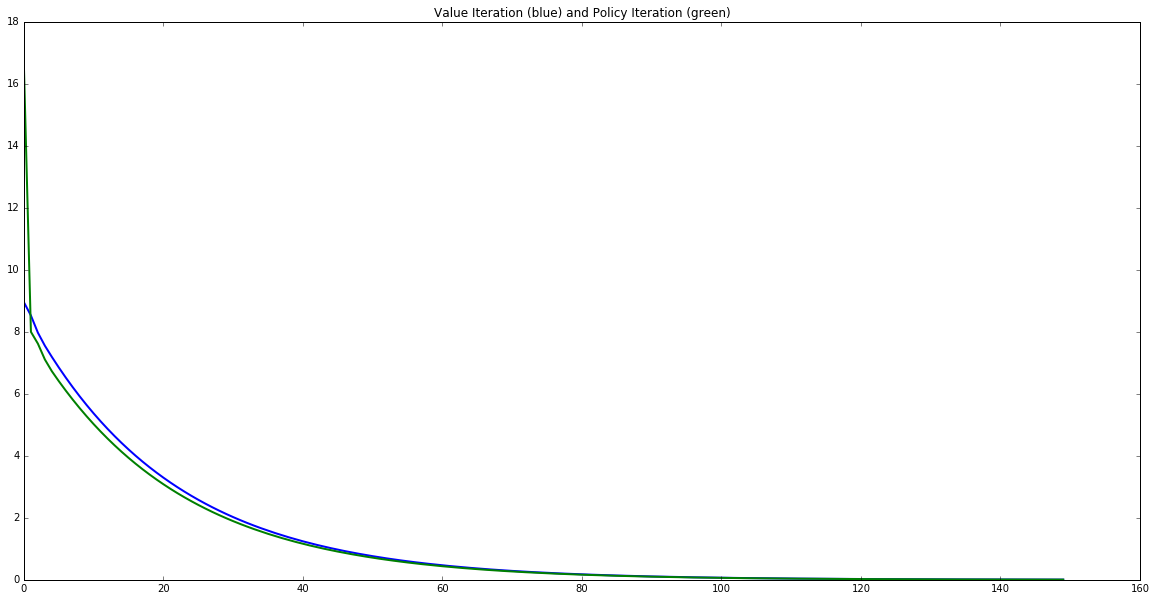

In [26]:
mpl.figure(figsize=(20,10))
mpl.title("Value Iteration (blue) and Policy Iteration (green)")
mpl.plot([max(abs(np.array(Vet)-np.array(valueIteration(k)[0]))) for k in range(150)], 'b', linewidth = 2)
mpl.plot([max(abs(np.array(Vet)-np.array(policyIteration(k)[0]))) for k in range(150)], 'g', linewidth = 2)
mpl.show()

In [146]:
def QLearning(n, Tmax, h0, eps):
    
    optimal_policy = np.empty((hmax,1))
    
    C = 1
    beta = 4/5
    
    alpha = lambda n: min(1,C*n**(-beta))
    
    N = np.zeros([hmax,2])
    Qt = np.zeros([hmax,2])
    
    rews = np.empty([0])
        
    for i in range(n):
        
        T = 0
        h = h0

        rew = np.empty([0])
        
        for T in range(Tmax):
            
            if rd.random() < 1-eps:
                amax = np.argmax(Qt[h-1])
            else:
                amax = rd.random() > .5
            
            h_1,r = tree_sim(h,amax)
            
            N[h-1,amax] += 1
            
            Qt[h-1,amax] = (1-alpha(N[h-1,amax]))*Qt[h-1,amax] + alpha(N[h-1,amax])*(r + gamma*max(Qt[h_1-1]))
            
            h = h_1
            
            rew = np.append(rew,r)
            
        rews = np.append(rews,np.sum(rew))
        
        optimal_policy = np.concatenate((optimal_policy,np.transpose([np.argmax(Qt,1)])),1)
           
#     np.set_printoptions(suppress=True)
    return Qt,optimal_policy,rews
    
    

In [147]:
QLearning(1000,100,10,.05)[1][:,-1]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


array([ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [143]:
Qopt = np.round([[Q(x,a,Vet) for a in range(2)] for x in range(1,hmax+1)],2)
Qopt

array([[  8.95,   8.52],
       [  9.65,   9.52],
       [ 10.45,  10.52],
       [ 11.31,  11.52],
       [ 12.17,  12.52],
       [ 13.03,  13.52],
       [ 13.84,  14.52],
       [ 14.61,  15.52],
       [ 15.25,  16.52],
       [ 15.68,  17.52]])

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0
10
20
30
40


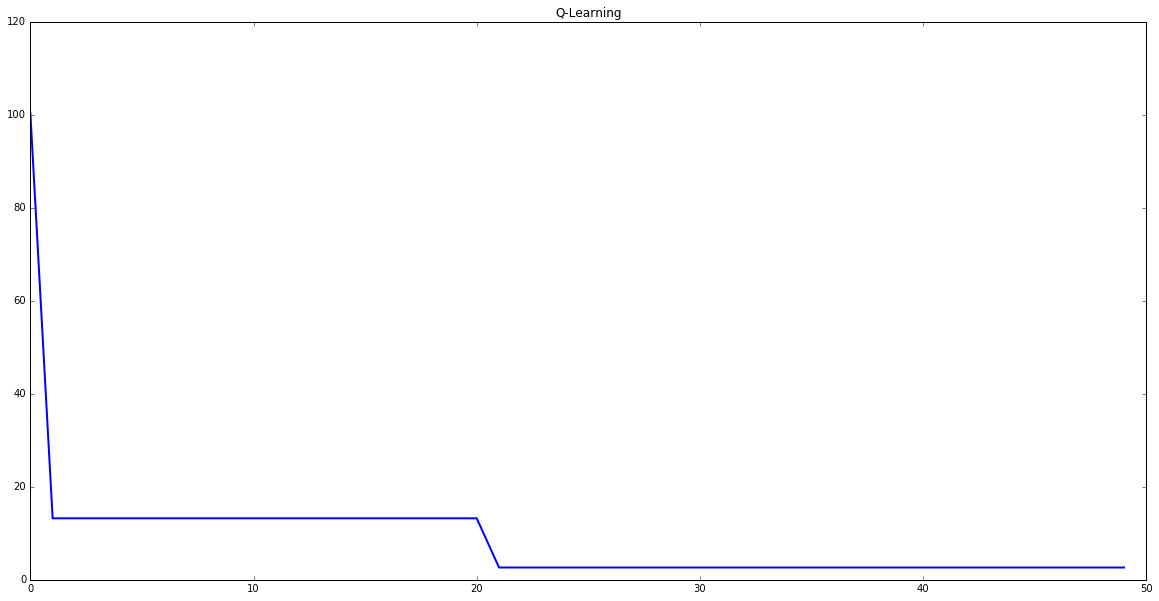

In [148]:
mpl.figure(figsize=(20,10))
mpl.title("Q-Learning")
values = np.empty([0])
Qvalues = QLearning(100,1000,1,.05)[1]
for k in range(50):
    values = np.append(values,max(abs(np.array(Vet)-BellmanVf(100,Qvalues[:,k]))))
    if k%10 == 0:
        print(k)
mpl.plot(values, 'b', linewidth = 2)
mpl.show()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


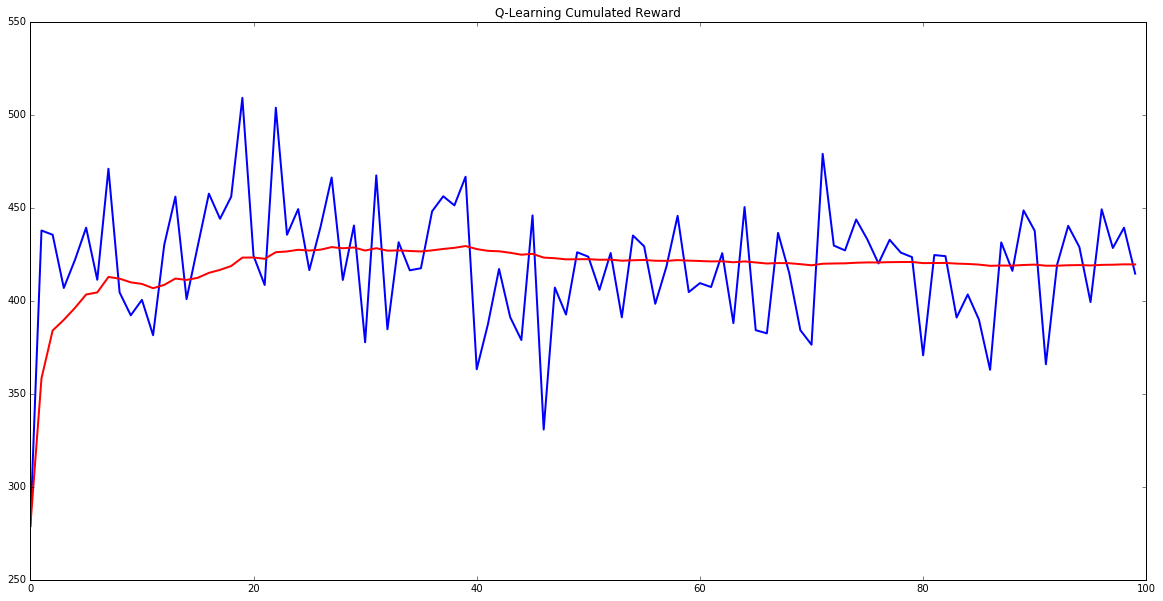

In [158]:
mpl.figure(figsize=(20,10))
mpl.title("Q-Learning Cumulated Reward")
Qvalues = QLearning(100,1000,1,.05)[2]
mpl.plot(Qvalues, 'b', linewidth = 2)
mpl.plot(np.cumsum(Qvalues)/np.array(range(1,len(Qvalues)+1)), 'r', linewidth = 2)
mpl.show()